# Spatial Analyses: vulnerability to lead poisoing and exposure.

## Introduction
In this exercise, we perform common spatial queries and vector processing on census data at the block group and census track levels. The overall goal is to explore the distribution of metals and its association with various population groups. As a geospatial analyst and EPA consultant for the city of Syracuse, your task is to investigate the relationship between metal concentration (in particular lead) and population. In particular, research suggests higher concentration of metals in minorities. In addition, children are more at risk of lead poisoning. 

## Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.

In [2]:
####################################    Spatial Analyses: SYRACUSE   #######################################
#######################################  Analyse data from Census #######################################
#This script performs basic analyses for the Exercise 1 of the workshop using Census data.
# The overall goal is to explore spatial autocorrelation and aggregation of units of analyses.     
#
#AUTHORS: Benoit Parmentier                                             
#DATE CREATED: 12/29/2018 
#DATE MODIFIED: 03/14/2019
#Version: 1
#PROJECT: AAG 2019 workshop preparation
#TO DO:
#
#COMMIT: added Moran'I and spatial regression, AAG workshop
#Useful links:
#sudo mount -t vboxsf C_DRIVE ~/c_drive

##################################################################################################

###### Library used in this script

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import descartes
import libpysal as lp #new pysal interface
from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
import pysal as ps


The list of packages above constains some of the most common packages used in geospatial data processing, wrangling and analysis. Notables spatial packages are "geopandas", "rasterio", "pysal", "gdal" and "shapely". Geopandas extends the "pandas" package to allow for the use of spatial data using a geometry column in a DataFrame. It implements a version of the Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allow operations and processing on raster layers. The "Pysal" package provides spatial analyses tools such as Moran's I and spatial regression modeling. In this exercise, we also use pysal for the OLS regression.  

## Functions

In the next part of the script, we declare all the functions used in the sripts. The first function builds outputs directory while the second function helps in the fitting and testing of the regression model. It is good practice to place functions at the beginning of a script or an external source file.

In [215]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [216]:
############################################################################
#####  Parameters and argument set up ###########

#ARGS 1
in_dir="/nfs/bparmentier-data/Data/workshop_spatial/climate_regression/data/"
#in_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/climate_regression/data"
#ARGS 2
out_dir="/nfs/bparmentier-data/Data/workshop_spatial/climate_regression/outputs"
#out_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/climate_regression/outputs"
#ARGS 3
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "exercise4_03252019" #output suffix for the files and ouptut folder
#ARGS 5
NA_value = -9999 # NA flag balue
#ARGS 6
file_format = ".tif"

#ARGS 7
#epsg 2991
crs_reg = "+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=400000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

#ARGS 8
infile_lst_month1 = "lst_mean_month1_rescaled.tif" 
#ARGS 9
infile_lst_month7 = "lst_mean_month7_rescaled.tif" 
#ARGS 10
ghcn_filename = "ghcn_or_tmax_covariates_06262012_OR83M.shp" # climate stations
##ARGS 11
prop = 0.3
#ARGS 12
random_seed= 100

## Input and output directories

Before any analyses, we start the script by creating a new output directory to store new files generated througout the script. Separating inputs from outputs avoids overwriting or modifiying the input source files. It is likely that you will repeath the analyses multiples times and generating a new output directory with a date or version can also help in tracking modeling and analyses outputs with different input arguments. 

In [217]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

directory already exists


## Reading visualizing data

Part I consists in reading in weather stations data in geopandas DataFrame and loading raster images from MODIS in rasterio objects. We explore the datasets by examining the coordinate systems, size (use "shape") and by displaying a few rows of the new geopanda data frame.

In [218]:
###########################################
### PART I: READ AND VISUALIZE DATA #######

data_gpd = gpd.read_file(os.path.join(in_dir,ghcn_filename)) 
## Extracting information from raster using raster io object
lst1 = rasterio.open(os.path.join(in_dir,infile_lst_month1))
lst7 = rasterio.open(os.path.join(in_dir,infile_lst_month7))
print(type(lst1))
print("Coordinate reference system: ",lst1.crs ) 
      
print(" Rows and columns: ", lst1.shape, "number of rows: ", lst1.height)  

data_gpd.head()  


<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",43],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_origin",41.75],PARAMETER["central_meridian",-120.5],PARAMETER["false_easting",400000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
 Rows and columns:  (536, 745) number of rows:  536


,station,year,month,day,element,value,mflag,qflag,sflag,lat,...,mmv_05,mmv_06,mmv_07,mmv_08,mmv_09,mmv_10,mmv_11,mmv_12,date,geometry
0,USC00350036,2010,1,1,TMAX,-9999,None,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100101,POINT (449915.4473939174 47537.72616197648)
1,USC00350036,2010,2,1,TMAX,61,0,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100201,POINT (449915.4473939174 47537.72616197648)
2,USC00350036,2010,3,1,TMAX,122,0,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100301,POINT (449915.4473939174 47537.72616197648)
3,USC00350036,2010,4,1,TMAX,44,0,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100401,POINT (449915.4473939174 47537.72616197648)
4,USC00350036,2010,5,1,TMAX,-9999,None,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100501,POINT (449915.4473939174 47537.72616197648)


Rasterio provides easy tools to display raster images. We compare the distributio of LST temperatures for the month of July and January.


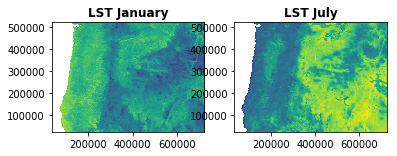

In [219]:
#Generate quick visualization using rasterio object
f, ax = plt.subplots(1, 2)

plot.show(lst1,title="LST January",ax=ax[0])
plot.show(lst7,title="LST July",ax=ax[1])


To manipulate raster data, we read in raster bands directly in numpy arrays and visualize the information. Once, we have arrays, we can perform most of the map algebra or arithmetical operations. We examine differences in temperature between July and January and create a new image (numpy array). From the map display, we can see that larger differences occurs in the eastern part of Oregon. Note that reading raster imagery in arrays may be problematic when we have large images. Alternatives may be to use GDAL tools such gdalcalc to perform map algebra and arithmetical operations as GDAL does not require reading information in memory directly.

Data type for r_lst1 object:  <class 'numpy.ma.core.MaskedArray'>


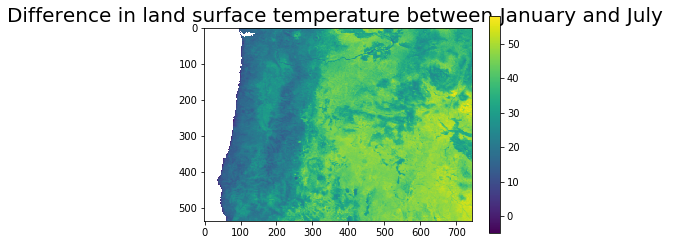

In [220]:
## Read raster bands directly to Numpy arrays and visualize data
r_lst1 = lst1.read(1,masked=True) #read first array with masked value, nan are assigned for NA
r_lst7 = lst7.read(1,masked=True) #read first array with masked value, nan are assigned for NA

spatial_extent = rasterio.plot.plotting_extent(lst1)
print("Data type for r_lst1 object: ",type(r_lst1))
r_lst1.size

r_diff = r_lst7 - r_lst1
plt.imshow(r_diff);
# other way to display data
plt.title("Difference in land surface temperature between January and July ", fontsize= 20)
plt.colorbar()


It is also useful to examine temperature distribution for January and July using histograms (we use the matplotlib package). Note that we had to extend the the limits of values for the LST temperatures since LST values are substantially higher for July. 

Text(0, 0.5, 'Frequency')

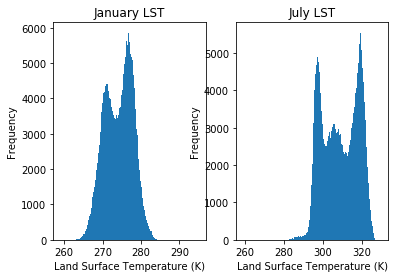

In [221]:
# Explore values distribution
f, ax = plt.subplots(1, 2)
ax[0].hist(r_lst1.ravel(),
         bins=256,
         range=(259.0,295.0));
ax[0].set_title('January LST')
ax[0].set_xlabel('Land Surface Temperature (K)')
ax[0].set_ylabel('Frequency')

ax[1].hist(r_lst7.ravel(),
         bins=256,
         range=(259.0,330));
ax[1].set_title('July LST')
ax[1].set_xlabel('Land Surface Temperature (K)')
ax[1].set_ylabel('Frequency')

# Combine raster and vector layers on same plot

It is often useful to display both vector and raster layers on the same plot. This can be done using the rasterio package or the standard matplotlib utility. We must first generate a "ax" plot object to add a layer on a existing plot figure.

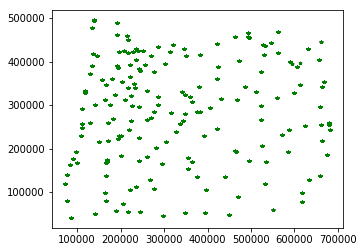

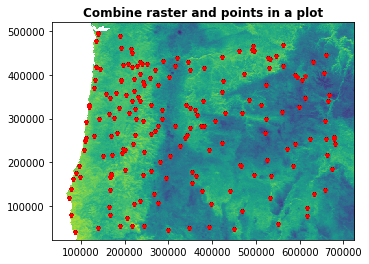

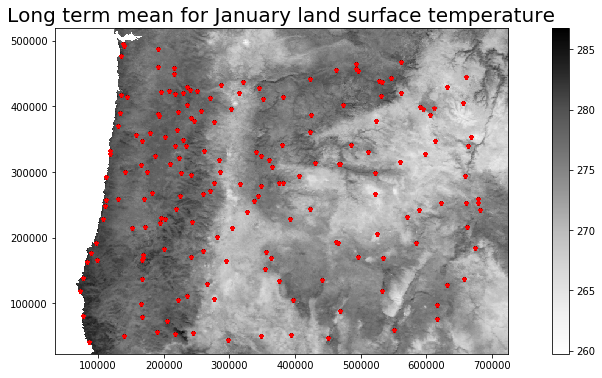

In [222]:
##### Combine raster layer and geogpanda layer

data_gpd.plot(marker="*",color="green",markersize=5)
station_or = data_gpd.to_crs({'init': 'epsg:2991'}) #reproject to  match the  raster image

##### How to combine plots with rasterio package
fig, ax = plt.subplots()
rasterio.plot.show(lst1,ax=ax,
                          clim=(259.0,287.0),
                  title="Combine raster and points in a plot")
station_or.plot(ax=ax,marker="*",
              color="red",
               markersize=10)
               
##### How to combine plots with matplotlib package
fig, ax = plt.subplots(figsize = (16,6))
lst_plot = ax.imshow(r_lst1, 
                       cmap='Greys', 
                       extent=spatial_extent)
station_or.plot(ax=ax,marker="*",
              color="red",
               markersize=10)
ax.set_title("Long term mean for January land surface temperature", fontsize= 20)
fig.colorbar(lst_plot)


## PART II: Extract information from raster and prepare covariates

We use the "georaster" package to extract values from the rasters of Land Surface Temperature for the month of January and July. The extraction is based on the x and y coordinates of points from the geopandas DataFrame. We directly add the extracted values to the geopanda DataFrame with new columns.

,LST1,LST7
0,280.020691,318.788666
1,280.020691,318.788666
2,280.020691,318.788666
3,280.020691,318.788666
4,280.020691,318.788666


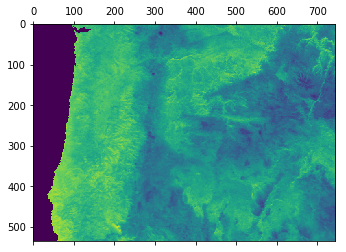

In [223]:
###########################################
### PART II : Extract information from raster and prepare covariates #######

lst1_gr = gr.from_file(os.path.join(in_dir,infile_lst_month1))
lst7_gr = gr.from_file(os.path.join(in_dir,infile_lst_month7))

type(lst1_gr) # check that we have a georaster object
# Plot data
lst1_gr.plot(clim=(259.0, 287.0))

#### Extract information from raster using coordinates
x_coord = station_or.geometry.x # pands.core.series.Series
y_coord = station_or.geometry.y
# Find value at point (x,y) or at vectors (X,Y)
station_or['LST1'] = lst1_gr.map_pixel(x_coord,y_coord)
station_or['LST7'] = lst7_gr.map_pixel(x_coord,y_coord)

station_or[['LST1','LST7']].head()

The values extracted are in Kelvin degree and are repeated in each row. We convert values in degree C, and remove no data values (flag value is -9999). We compute averages at each weather station using the "groupby" pandas operator.The goal is to generate unique monthly LST values for each station. Note that we also need to rescale the GHCN network values to have comparable LST and ground measurements.

In [224]:
station_or.columns #get names of col

station_or['year'].value_counts()
station_or.groupby(['month'])['value'].mean() # average by stations per month
     
print("number of rows:",station_or.station.count(),", number of stations:",len(station_or.station.unique()))
station_or['LST1'] = station_or['LST1'] - 273.15 #create new column
station_or['LST7'] = station_or['LST7'] - 273.15 #create new column

station_or_jan = station_or.loc[(station_or['month']==1) & (station_or['value']!=-9999)]
station_or_jul = station_or.loc[(station_or['month']==7) & (station_or['value']!=-9999)]

station_or_jan.head()
station_or_jan.columns
station_or_jan.shape

#avg_df = station_or.groupby(['station'])['value'].mean())
avg_jan_df = station_or_jan.groupby(['station'])['value','LST1','LST7'].mean()
avg_jul_df = station_or_jul.groupby(['station'])['value','LST1','LST7'].mean()

avg_jan_df.head()
avg_jan_df.shape
avg_jul_df.shape
avg_jan_df.head()
avg_jul_df.head()

avg_jan_df['T1'] = avg_jan_df['value']/10
avg_jul_df['T7'] = avg_jul_df['value']/10

avg_jan_df[['LST1','T1']].head()

number of rows: 67053 , number of stations: 186


,LST1,T1
station,,
USC00350036,6.870697,6.640741
USC00350118,3.755188,7.542857
USC00350145,4.750732,10.064286
USC00350197,2.684601,7.183333
USC00350265,3.665344,7.061290


##  PART III : Fit model and generate predictions

We split the stations into training and testing sets and use the proportion of hold out defined in argument (ARGS 8: prop=0.3) with the sklearn functionalities. To make results reproducible, we set the random seed to specific value (see ARGS 9). We will use the training values to fit the regression model and the testing values to assess accuracy of the predictions.


In [225]:
################################################
###  PART III : Fit model and generate prediction

#selected_covariates_names_updated = selected_continuous_var_names + names_cat 
selected_features = ['LST1'] #selected features
selected_target = ['T1'] #selected dependent variables
## Split training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(avg_jan_df[selected_features], 
                                                    avg_jan_df[selected_target], 
                                                    test_size=prop, 
                                                    random_state=random_seed)
   
X_train.shape
y_train.shape


(125, 1)

We use the "linear_model" tool from the sklearn package to istantiate a modeling object. Fitting is provived by the general fit method and prediction on dataset can be obtained using the predict method.

In [226]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression() #create/instantiate object used for linear regresssion
regr.fit(X_train,y_train) #fit model

y_pred_train = regr.predict(X_train) # Note this is a fit!
y_pred_test = regr.predict(X_test) # Note this is a fit!


## Model evaluation

To evaluate the models, we can use many different accuracy metrics. In this excercise, we use the coefficient of determination (R2), the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE). We generate these metrics for both the training and testing sets and store the information and pandas DataFrame.


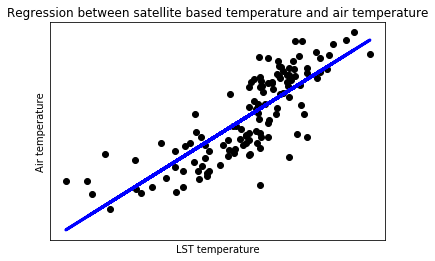

reg coef [[0.6977205]]
reg intercept [5.9161386]


In [227]:
#### Model evaluation
from sklearn import metrics
#https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics
r2_val_test = regr.score(X_test, y_test)
mae_val_test = metrics.mean_absolute_error(y_test, y_pred_test) #MAE
rmse_val_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)) #RMSE

r2_val_train = regr.score(X_train, y_train) #coefficient of determination (R2)
rmse_val_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)) #RMSE
mae_val_train = metrics.mean_absolute_error(y_test, y_pred_test)

data = np.array([[mae_val_test,rmse_val_test,r2_val_test],[mae_val_train,rmse_val_train,r2_val_train]])
    
data_metrics_df = pd.DataFrame(data,columns=['mae','rmse','r2'])
data_metrics_df['test']=[1,0]
#metrics.r2_scores(y_test, y_pred_test)

plt.scatter(X_train, y_train,  color='black')
plt.plot(X_train, regr.predict(X_train), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.xlabel("LST temperature")
plt.ylabel("Air temperature")
plt.title("Regression between satellite based temperature and air temperature")
plt.show()

print('reg coef',regr.coef_)
print('reg intercept',regr.intercept_)


## Use function provided and assess models for January and July

In the example above, we showed how to generate the accuracy metrics using January as input. We now use the function defined at the beginning of the script to fit and assess the model for the month of January and July. This function also provides residuals. Residuals are differences between the predicted and observed values. Most accuracy metrics use residuals as input.

In [213]:
selected_features = ['LST1'] #selected features
selected_target = ['T1'] #selected dependent variables

fit_ols_jan = fit_ols_reg(avg_df=avg_jan_df,
            selected_features = selected_features,
            selected_target = selected_target,
            prop=0.3,
            random_seed=10)

selected_features = ['LST7'] #selected features
selected_target = ['T7'] #selected dependent variables

fit_ols_jul = fit_ols_reg(avg_df=avg_jul_df,
            selected_features = selected_features,
            selected_target = selected_target,
            prop=0.3,
            random_seed=10)

data_metrics = pd.concat([fit_ols_jan[4],fit_ols_jul[4]])
data_metrics['month'] = [1,1,7,7] 
data_metrics

residuals_jan_df =fit_ols_jan[3]
residuals_jul_df =fit_ols_jul[3]

residuals_jan_df.columns
residuals_jan_df['test'] = residuals_jan_df['test'].astype('category')
outfile = os.path.join(out_dir,"residuals_jan_df_"+out_suffix+".csv")
residuals_jan_df.to_csv(outfile)

residuals_jul_df['test'] = residuals_jul_df['test'].astype('category')
outfile = os.path.join(out_dir,"residuals_jul_df_"+out_suffix+".csv")
residuals_jul_df.to_csv(outfile)


To asses model, we look at patterns from residuals and the metrics produced. We use boxplot from the seaborn package to examine the distribution of residuals for January and July month. We have larger spread of values in July than January and metrics indicate that predictions are better in January than July. For instance, January MAE for the testing set is 1.48 C while MAE for July is 2.24 C. The coefficient of determination also suggest that relationship between LST and temperature are stronger in January than July. 

,mae,rmse,r2,test,month
0,1.481670,1.808971,0.629309,1,1
1,1.428433,1.773297,0.677287,0,1
0,2.244182,2.719970,0.574908,1,7
1,2.334993,2.916917,0.575326,0,7


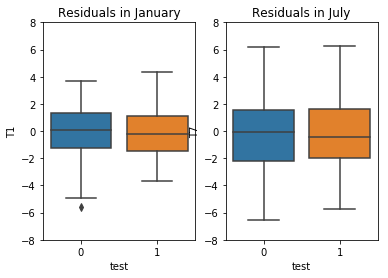

In [207]:
#Note that we had to change data type to categorical for the variable used on the x-axis!

f, ax = plt.subplots(1, 2)
sns.boxplot(ax=ax[0],x='test',y='T1',data=residuals_jan_df)#title='January residuals')
ax[0].set(ylim=(-8, 8)) 
ax[0].set(title="Residuals in January") 

sns.boxplot(ax=ax[1],x='test',y='T7',data=residuals_jul_df) #title='July residuals')
ax[1].set(ylim=(-8, 8)) 
ax[1].set(title="Residuals in July") 

data_metrics.head()

###################### END OF SCRIPT ################################


## Conclusions

This study explored the potential of using Land Surface Temperature (LST) observed from a satellite to predict ground temperature. We used LST from the MODIS Terra sensor and GHCN weather station measurements and found that that LST provides useful information with a strong relationship. This work was exploratory and more work can be done to refine the model by adding covariates and/or changing the specification (e.g. use Generalized Additive Model). In particular, the literature suggest that Elevation is a strong predictor for air temperature and can be used with satellite measurements. The relationship between LST and air temperature is also associated with the land cover. Stronger relationships are found in areas covered by vegetation (e.g. Forest). 

## References

Benali, A, Carvalho, AC, Nunes, JP, Carvalhais, N, Santos, A. 2012. Estimating air surface temperature in Portugal using MODIS LST data. Remote Sens. Environ. 124: 108– 121.

Fick, S.E. & Hijmans, R.J. ( 2017) WorldClim 2: new 1‐km spatial resolution climate surfaces for global land areas. International Journal of Climatology, 37, 4302– 4315.

Mildrexler, DJ, Zhao, M, Running, SW. 2011. A global comparison between station air temperatures and MODIS land surface temperatures reveals the cooling role of forests. J. Geophys. Res. 116: G03025.

Parmentier, B, McGill, B, Wilson, AM, Regetz, J, Jetz, W, Guralnick, RP, Tuanmu, M, Robinson, N, Schildhauer, M. 2014. An assessment of methods and remotely sensed derived covariates for regional predictions of 1 km daily maximum air temperature. Remote Sens. 6( 9): 8639– 8670.

Parmentier, B, McGill, BJ, Wilson, AM, Regetz, J, Jetz, W, Guralnick, R, Tuanmu, M‐N, Schildhauer, M. 2015. Using multi‐timescale methods and satellite‐derived land surface temperature for the interpolation of daily maximum air temperature in Oregon. Int. J. Climatol. 35: 3862– 3878.
